# Proyek Klasifikasi Gambar: Animal Classification
- **Nama:** Aulia Putri Fanani
- **Email:** liapuutri2007@gmai.com
- **ID Dicoding:** MC006D5X1464

- Dataset yang digunakan adalah :
https://www.kaggle.com/datasets/bhavikjikadara/dog-and-cat-classification-dataset

- Klasifikasi digunakan untuk mengklasifikasikan kategori data gambar kucing, anjing dan hewan hutan (cat, dog, wild)

## Import Semua Packages/Library yang Digunakan

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [3]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"auliaptrf","key":"a84a24b50ef713d6d8ad9a09f52140ef"}'}

In [4]:
# Install Kaggle API client.
!pip install -q kaggle

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Ubah permission kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Download kaggle dataset and unzip the file
!kaggle datasets download -d andrewmvd/animal-faces

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)


In [7]:
!ls

animal-faces.zip  kaggle.json  sample_data


In [8]:
!unzip animal-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: afhq/train/wild/flickr_wild_001378.jpg  
  inflating: afhq/train/wild/flickr_wild_001379.jpg  
  inflating: afhq/train/wild/flickr_wild_001380.jpg  
  inflating: afhq/train/wild/flickr_wild_001381.jpg  
  inflating: afhq/train/wild/flickr_wild_001382.jpg  
  inflating: afhq/train/wild/flickr_wild_001384.jpg  
  inflating: afhq/train/wild/flickr_wild_001385.jpg  
  inflating: afhq/train/wild/flickr_wild_001386.jpg  
  inflating: afhq/train/wild/flickr_wild_001387.jpg  
  inflating: afhq/train/wild/flickr_wild_001388.jpg  
  inflating: afhq/train/wild/flickr_wild_001389.jpg  
  inflating: afhq/train/wild/flickr_wild_001390.jpg  
  inflating: afhq/train/wild/flickr_wild_001391.jpg  
  inflating: afhq/train/wild/flickr_wild_001392.jpg  
  inflating: afhq/train/wild/flickr_wild_001393.jpg  
  inflating: afhq/train/wild/flickr_wild_001394.jpg  
  inflating: afhq/train/wild/flickr_wild_001395.jpg  
  inflating: afhq/train/wild/fl

### Data Preprocessing

In [10]:
# Direktori awal untuk train dan test
train_dir = "/content/afhq/train"
test_dir = "/content/afhq/val"

# Direktori baru untuk dataset gabungan
combined_dir = "/content/afhq/dataset"

In [11]:
# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

In [12]:
# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

#### Data Checking

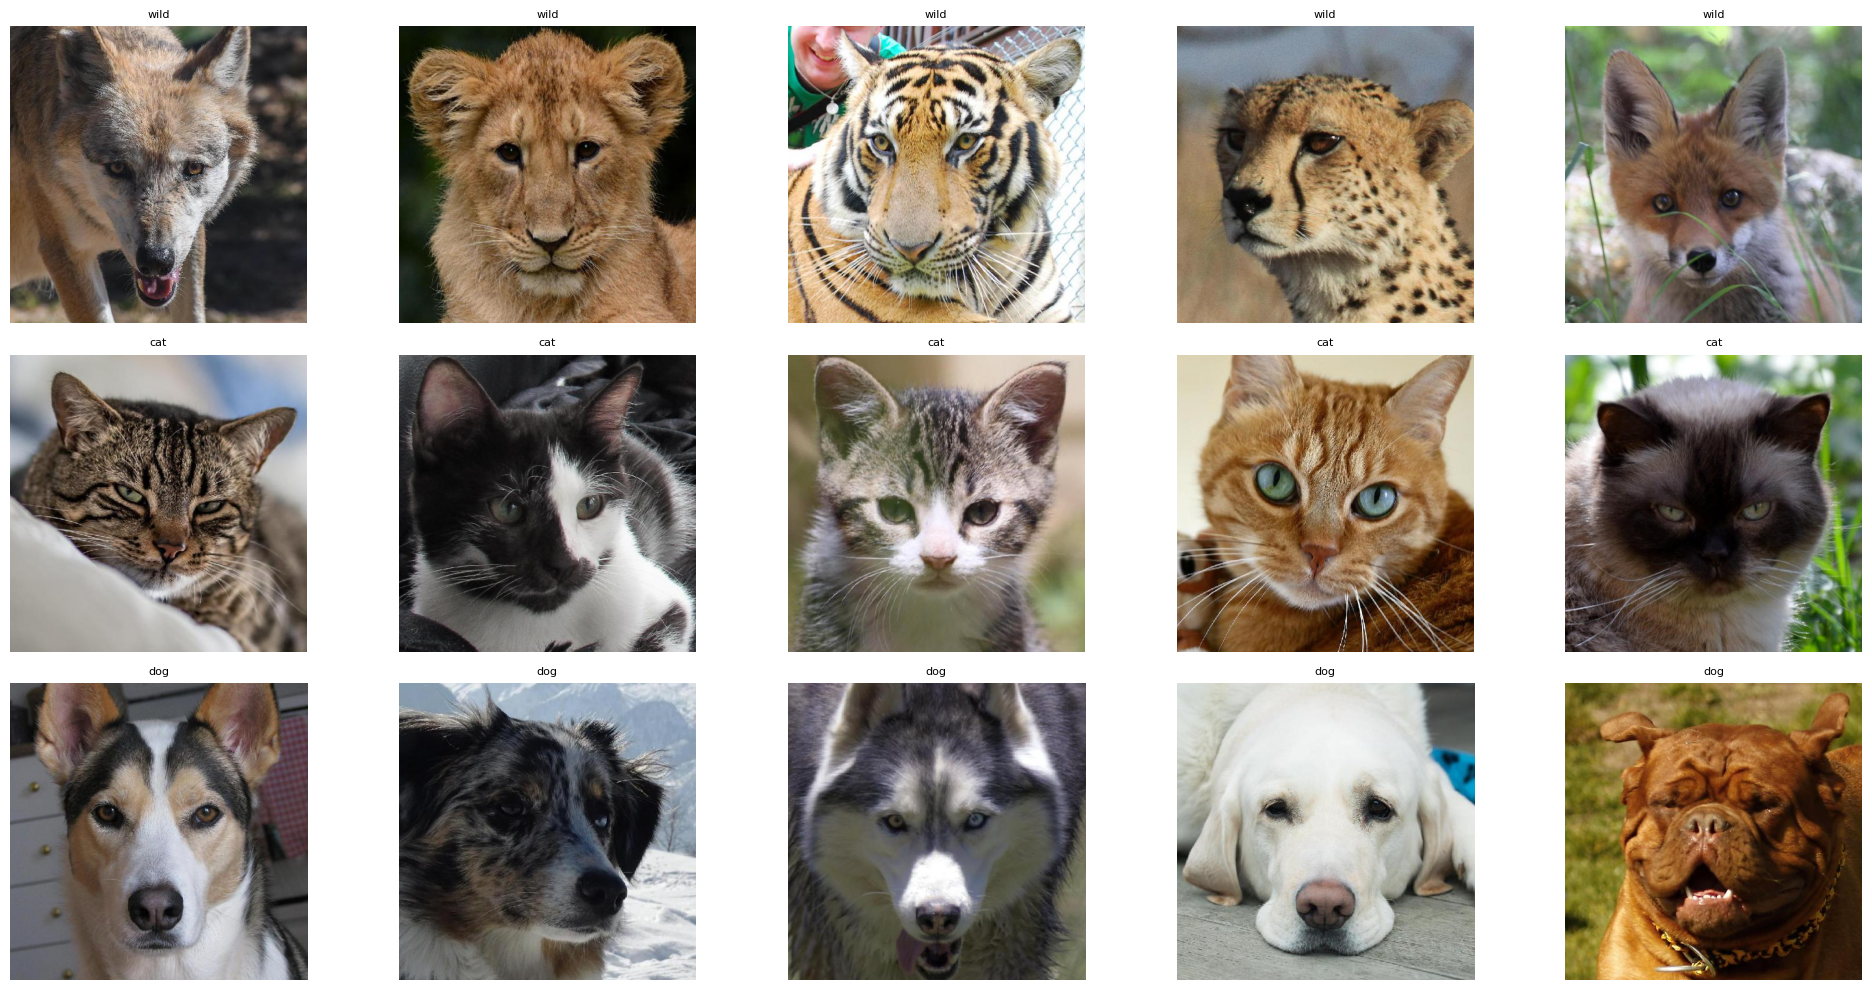

In [13]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas
animal_images = {}

# Tentukan path dataset (sesuaikan dengan struktur folder hasil unzip)
path = "/content/afhq/train"
for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):  # Pastikan ini adalah folder kelas
        animal_images[class_name] = os.listdir(class_path)

# Menampilkan 5 gambar acak dari setiap kelas
fig, axs = plt.subplots(len(animal_images.keys()), 5, figsize=(20, 10))

for i, class_name in enumerate(animal_images.keys()):
    # Pilih 5 gambar acak (jika kelas memiliki minimal 5 gambar)
    available_images = animal_images[class_name]
    num_samples = min(5, len(available_images))
    images = np.random.choice(available_images, num_samples, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        try:
            img = Image.open(img_path).convert("RGB")
            axs[i, j].imshow(img)
            axs[i, j].set_title(class_name, fontsize=8)
            axs[i, j].axis('off')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            axs[i, j].axis('off')

plt.tight_layout()
plt.show()

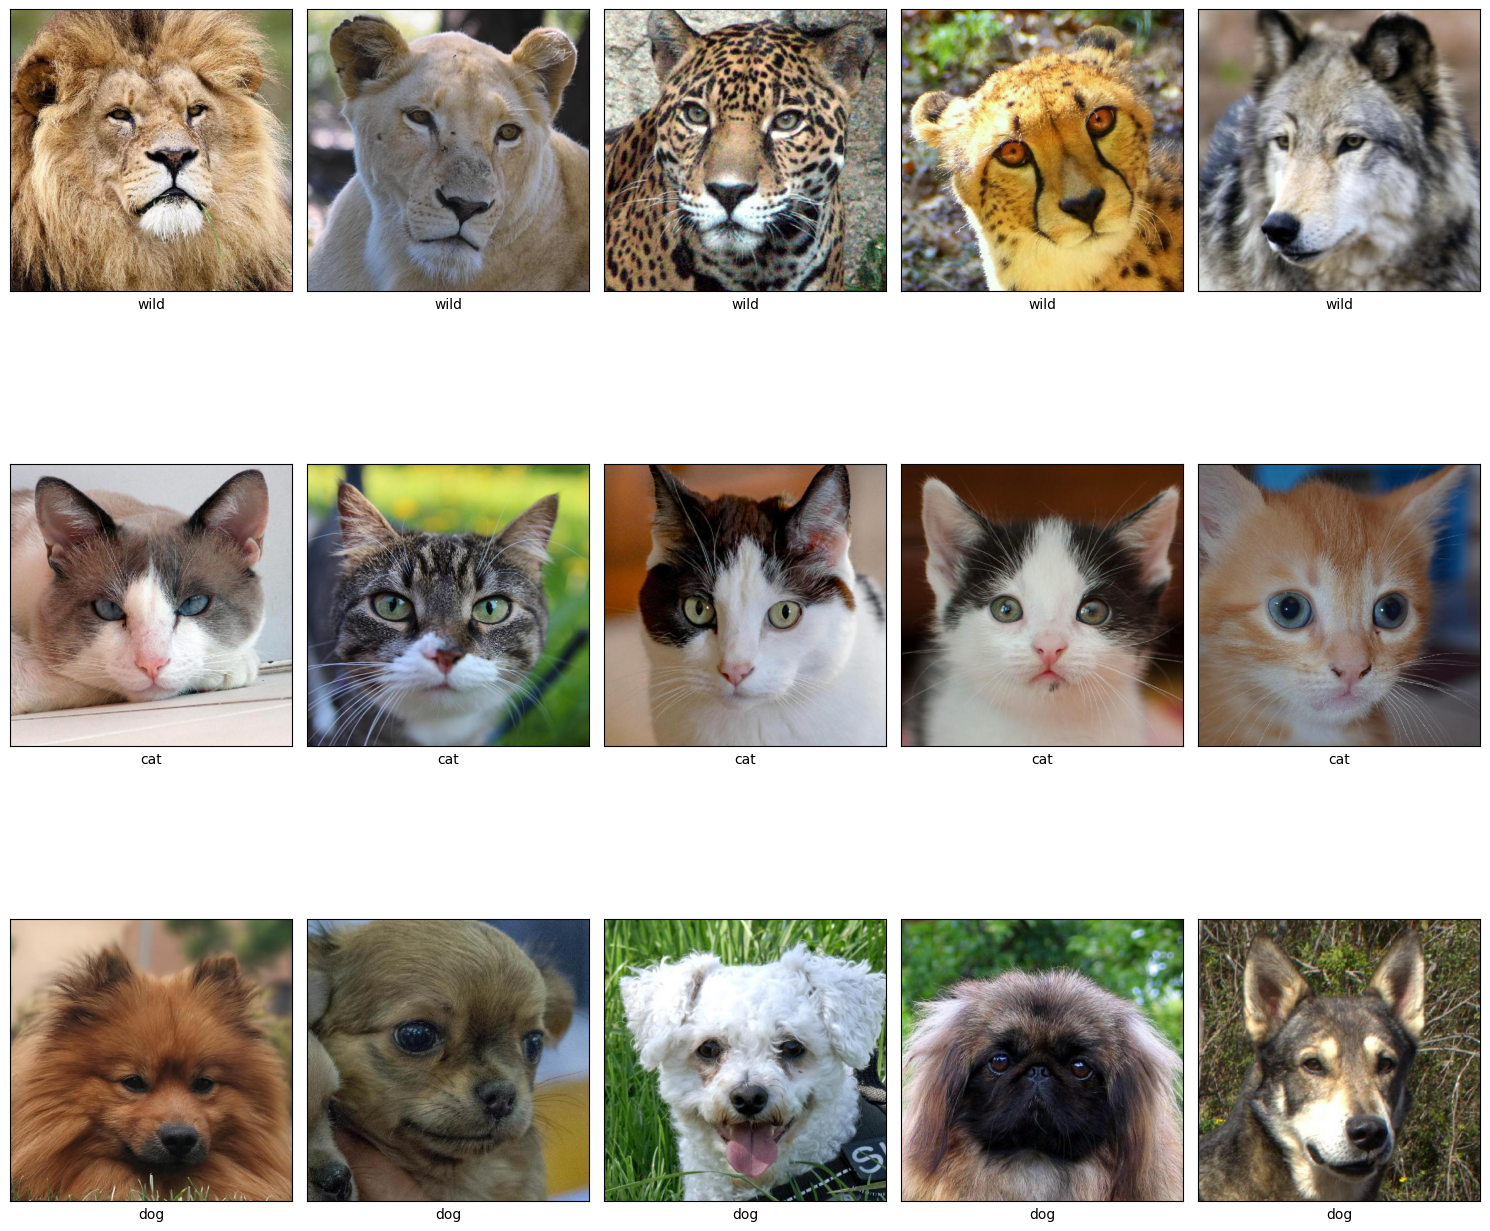

In [14]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
animal_images = {}

# Tentukan path sumber train
path = "/content/afhq"
path_sub = os.path.join(path, "train")
for i in os.listdir(path_sub):
    animal_images[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(animal_images.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(animal_images[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("RGB")  # Konversi menjadi skala RGB
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

#### Plot Distribusi

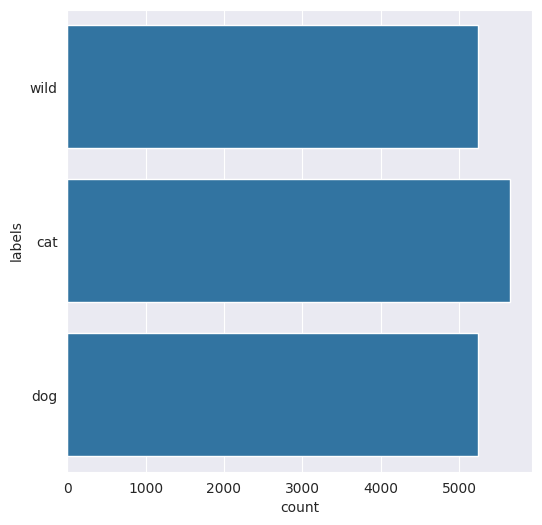

In [15]:
# Definisikan path sumber
lung_path = "/content/afhq/dataset/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

#### Data Augmentation

In [16]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [141]:
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

images_path = "/content/afhq/dataset"
augmented_path = "/content/afhq/dataset"
images = []

# Baca nama gambar dari folder dan tambahkan path ke dalam array "images"
for im in os.listdir(images_path):
    images.append(os.path.join(images_path, im))

#os.makedirs(augmented_path, exist_ok=True)

# Ambil semua path file gambar dari semua subfolder
images = []
for root, dirs, files in os.walk(images_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            full_path = os.path.join(root, file)
            if os.path.isfile(full_path):
                images.append(full_path)

# Jumlah gambar yang akan ditambahkan dengan hasil transformasi augmentasi
images_to_generate = 2000
i = 1

while i <= images_to_generate:
    image = random.choice(images)
    try:
        original_image = io.imread(image)

        # Memeriksa apakah gambar memiliki dimensi yang valid (3 atau 4 dimensi)
        if original_image.ndim not in [3, 4]:
            raise ValueError('Invalid image dimensions')

        transformed_image = None
        n = 0  # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations))  # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations))  # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        # Simpan hasil transformasi di folder label yang sesuai
        label_folder = image.split("/")[-2]  # Ambil label dari folder gambar asli
        save_dir = os.path.join(augmented_path, label_folder)
        os.makedirs(save_dir, exist_ok=True)  # Bikin folder kalau belum ada

        new_image_path = os.path.join(save_dir, f"augmented_image_{i}.jpg")
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i = i + 1
    except ValueError as e:
        print('Could not read or process the image', image, ':', e, 'hence skipping it.')

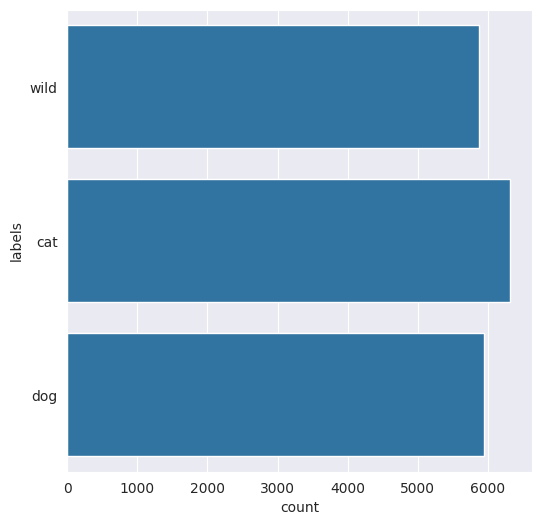

In [18]:
# Definisikan path sumber
animal_images = "/content/afhq/dataset/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(animal_images):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

#### Data Splitting

In [19]:
# Panggil variabel animal_images yang menampung folder dataset gambar
#animal_images= "/content/afhq/dataset"

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(animal_images):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

labels
cat     6318
dog     5945
wild    5867
dtype: int64

In [20]:
# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels

X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan temp (sementara)
X_train, X_temp, y_train, y_temp = train_test_split(
    df['path'], df['labels'], test_size=0.4, random_state=42
)

# Split dataset temp menjadi val dan test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

In [21]:
# Buat DataFrame untuk masing-masing set
df_train = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_val = pd.DataFrame({'path': X_val, 'labels': y_val, 'set': 'val'})
df_test = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

In [22]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_train))
print('test size', len(df_val))
print('train size', len(df_test))

train size 10878
test size 3626
train size 3626


In [23]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels
test   cat       1252
       dog       1186
       wild      1188
train  cat       3765
       dog       3562
       wild      3551
val    cat       1301
       dog       1197
       wild      1128
dtype: int64 


                                                   path labels    set
606   /content/afhq/dataset/cat/augmented_image_137.jpg    cat  train
7517  /content/afhq/dataset/cat/augmented_image_1971...    cat  train
4448   /content/afhq/dataset/dog/pixabay_dog_000209.jpg    dog  train
9930  /content/afhq/dataset/dog/augmented_image_398.jpg    dog  train
7886  /content/afhq/dataset/wild/flickr_wild_002160.jpg   wild  train


In [24]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "/content/afhq/dataset/"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

In [25]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

## Image Data Generator

In [26]:
# Definisikan direktori
TRAIN_DIR = "Dataset-Final/train/"
VAL_DIR = "Dataset-Final/val/"
TEST_DIR = "Dataset-Final/test/"

# Path untuk setiap kelas di setiap set
train_cat = os.path.join(TRAIN_DIR, 'cat')
train_dog = os.path.join(TRAIN_DIR, 'dog')
train_wild = os.path.join(TRAIN_DIR, 'wild')

val_cat = os.path.join(VAL_DIR, 'cat')
val_dog = os.path.join(VAL_DIR, 'dog')
val_wild = os.path.join(VAL_DIR, 'wild')

test_cat = os.path.join(TEST_DIR, 'cat')
test_dog = os.path.join(TEST_DIR, 'dog')
test_wild = os.path.join(TEST_DIR, 'wild')

# Hitung dan tampilkan jumlah gambar
print("=== Training Set ===")
print("Total cat images in training set:", len(os.listdir(train_cat)))
print("Total dog images in training set:", len(os.listdir(train_dog)))
print("Total wild images in training set:", len(os.listdir(train_wild)))

print("\n=== Validation Set ===")
print("Total cat images in validation set:", len(os.listdir(val_cat)))
print("Total dog images in validation set:", len(os.listdir(val_dog)))
print("Total wild images in validation set:", len(os.listdir(val_wild)))

print("\n=== Test Set ===")
print("Total cat images in test set:", len(os.listdir(test_cat)))
print("Total dog images in test set:", len(os.listdir(test_dog)))
print("Total wild images in test set:", len(os.listdir(test_wild)))

=== Training Set ===
Total cat images in training set: 3765
Total dog images in training set: 3562
Total wild images in training set: 3551

=== Validation Set ===
Total cat images in validation set: 1301
Total dog images in validation set: 1197
Total wild images in validation set: 1128

=== Test Set ===
Total cat images in test set: 1252
Total dog images in test set: 1186
Total wild images in test set: 1188


In [29]:
train_datagen = ImageDataGenerator(rescale=1/255)
val_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="rgb",
                                              class_mode='categorical',
                                              shuffle=True)

validation_generator = val_datagen.flow_from_directory(VAL_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   color_mode="rgb",
                                                   class_mode='categorical',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="rgb",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 10878 images belonging to 3 classes.
Found 3626 images belonging to 3 classes.
Found 3626 images belonging to 3 classes.


## Modelling

In [38]:
tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_1 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)))  # Channel terakhir = 1 (grayscale)
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (4, 4), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Flatten dan Dense Layers
model_1.add(Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.3))
model_1.add(Dense(3, activation='softmax'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_1.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss='categorical_crossentropy',  # Ganti binary_crossentropy
    metrics=['accuracy']
)

print(model_1.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,403,587 (5.35 MB)

 Trainable params: 1,403,395 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None


In [40]:
# Callbacks
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min')

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True)

In [41]:
count_cat = len(os.listdir(train_cat))
count_dog = len(os.listdir(train_dog))
count_wild = len(os.listdir(train_wild))

total_samples = count_cat + count_dog + count_wild
weight_0 = (1 / count_cat) * (total_samples) / 3.0
weight_1 = (1 / count_dog) * (total_samples) / 3.0
weight_2 = (1 / count_wild) * (total_samples) / 3.0

class_weights = {0: weight_0, 1: weight_1, 2: weight_2}

%time

# Fitting / training model
history_1 = model_1.fit(train_generator,
                        epochs=20,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights,
                        callbacks=[checkpoint, early_stopping]
                        )

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 10.3 µs
Epoch 1/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9510 - loss: 0.1518

340/340 ━━━━━━━━━━━━━━━━━━━━ 854s 3s/step - accuracy: 0.9510 - loss: 0.1518 - val_accuracy: 0.9261 - val_loss: 0.2022
Epoch 2/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 825s 2s/step - accuracy: 0.9601 - loss: 0.1357 - val_accuracy: 0.9322 - val_loss: 0.2194
Epoch 3/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 850s 2s/step - accuracy: 0.9663 - loss: 0.1083 - val_accuracy: 0.9068 - val_loss: 0.3862
Epoch 4/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9738 - loss: 0.0921

340/340 ━━━━━━━━━━━━━━━━━━━━ 814s 2s/step - accuracy: 0.9738 - loss: 0.0921 - val_accuracy: 0.9432 - val_loss: 0.1948
Epoch 5/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 826s 2s/step - accuracy: 0.9736 - loss: 0.0853 - val_accuracy: 0.9374 - val_loss: 0.2164
Epoch 6/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 859s 2s/step - accuracy: 0.9765 - loss: 0.0831 - val_accuracy: 0.8977 - val_loss: 0.4270
Epoch 7/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 812s 2s/step - accuracy: 0.9811 - loss: 0.0644 - val_accuracy: 0.9520 - val_loss: 0.1972
Epoch 8/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 813s 2s/step - accuracy: 0.9802 - loss: 0.0711 - val_accuracy: 0.9352 - val_loss: 0.2921
Epoch 9/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9829 - loss: 0.0670

340/340 ━━━━━━━━━━━━━━━━━━━━ 841s 2s/step - accuracy: 0.9829 - loss: 0.0670 - val_accuracy: 0.9647 - val_loss: 0.1866
Epoch 10/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 816s 2s/step - accuracy: 0.9825 - loss: 0.0697 - val_accuracy: 0.9545 - val_loss: 0.3684
Epoch 11/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 861s 2s/step - accuracy: 0.9837 - loss: 0.0600 - val_accuracy: 0.9589 - val_loss: 0.3008
Epoch 12/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 821s 2s/step - accuracy: 0.9839 - loss: 0.0594 - val_accuracy: 0.9570 - val_loss: 0.2010
Epoch 13/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 898s 3s/step - accuracy: 0.9861 - loss: 0.0500 - val_accuracy: 0.9550 - val_loss: 0.3503
Epoch 14/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 842s 2s/step - accuracy: 0.9862 - loss: 0.0518 - val_accuracy: 0.9539 - val_loss: 0.2892


In [128]:
pd.DataFrame(history_1.history)

accuracy      loss  val_accuracy  val_loss
0   0.950726  0.154166      0.926089  0.202177
1   0.959459  0.145517      0.932157  0.219355
2   0.963137  0.114100      0.906784  0.386159
3   0.969480  0.105667      0.943188  0.194796
4   0.970307  0.096871      0.937397  0.216442
5   0.974444  0.089377      0.897683  0.426982
6   0.977477  0.082067      0.952013  0.197150
7   0.977110  0.087044      0.935190  0.292051
8   0.980603  0.072860      0.964699  0.186590
9   0.982442  0.068601      0.954495  0.368351
10  0.982809  0.065863      0.958908  0.300818
11  0.983453  0.063181      0.956977  0.200959
12  0.985751  0.057440      0.955047  0.350336
13  0.985751  0.058812      0.953944  0.289215

Proses pelatihan model berhenti lebih awal pada epoch ke-14. Hal ini terjadi karena penggunaan callback **EarlyStopping** yang secara otomatis menghentikan pelatihan jika tidak terjadi peningkatan yang signifikan pada performa model, khususnya pada metrik yang dimonitor seperti val_loss. Sehingga EarlyStopping memutuskan untuk menghentikan proses pelatihan guna mencegah overfitting dan menghemat waktu komputasi

## Evaluasi dan visualisasi

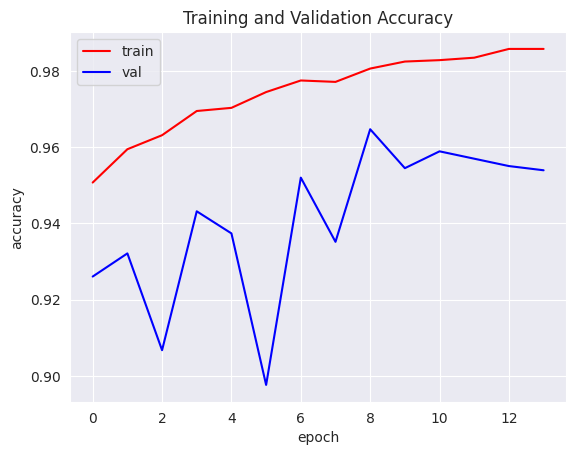

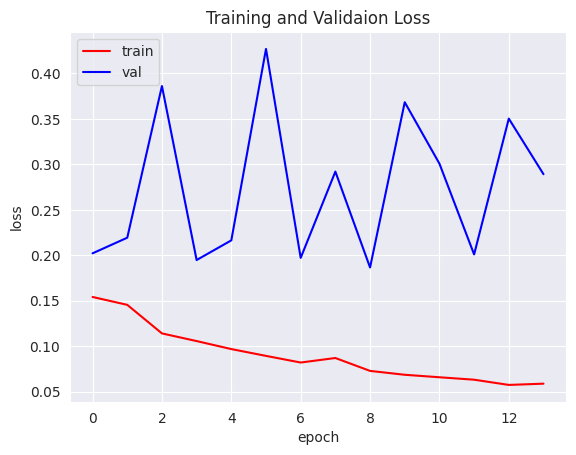

In [42]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [45]:
# Print nilai akhir
print(f"Final Training Accuracy: {acc[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")
print(f"Final Training Loss: {loss[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")

Final Training Accuracy: 0.9858
Final Validation Accuracy: 0.9539
Final Training Loss: 0.0588
Final Validation Loss: 0.2892




              precision    recall  f1-score   support

         Cat     0.9681    0.9681    0.9681      1252
         Dog     0.9373    0.9705    0.9536      1186
        Wild     0.9695    0.9352    0.9520      1188

    accuracy                         0.9581      3626
   macro avg     0.9583    0.9579    0.9579      3626
weighted avg     0.9585    0.9581    0.9581      3626



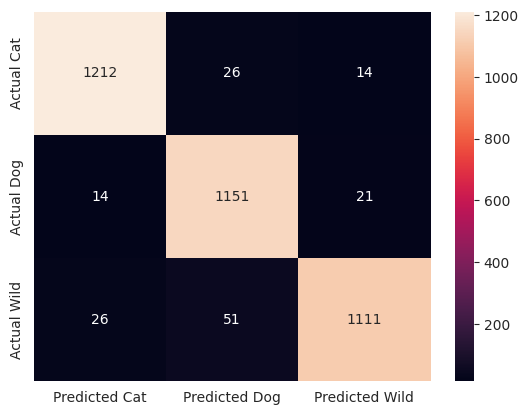

In [142]:
test_generator.reset()

# Test model dengan generator
preds_1 = model_1.predict(test_generator, verbose=0)
preds_1 = preds_1.copy()
preds_1 = np.argmax(preds_1, axis=1)
y_true = test_generator.classes

# Confussion Matrix
cm = pd.DataFrame(data=confusion_matrix(y_true, preds_1, labels=[0, 1, 2]),
                  index=["Actual Cat", "Actual Dog", "Actual Wild"],
                  columns=["Predicted Cat", "Predicted Dog", "Predicted Wild"])
sns.heatmap(cm, annot=True, fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=y_true, y_pred=preds_1, target_names=['Cat', 'Dog', 'Wild'], digits=4))

## Konversi Model

In [71]:
# Menyimpan model dalam format SavedModel
saved_path = "/content/Dataset-Final/SavedModel"
os.makedirs(saved_path, exist_ok=True)
tf.saved_model.save(model_1, saved_path)

In [72]:
!zip -r SavedModel.zip Dataset-Final/SavedModel

  adding: Dataset-Final/SavedModel/ (stored 0%)
  adding: Dataset-Final/SavedModel/fingerprint.pb (stored 0%)
  adding: Dataset-Final/SavedModel/variables/ (stored 0%)
  adding: Dataset-Final/SavedModel/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: Dataset-Final/SavedModel/variables/variables.index (deflated 65%)
  adding: Dataset-Final/SavedModel/assets/ (stored 0%)
  adding: Dataset-Final/SavedModel/saved_model.pb (deflated 88%)


In [64]:
# Menyimpan dan konversi ke TensorFlow Lite
save_path = "/content/Dataset-Final/TFLite"
os.makedirs(save_path, exist_ok=True)

converter = tf.lite.TFLiteConverter.from_saved_model("/content/Dataset-Final/SavedModel")
tflite_model = converter.convert()

# Simpan model TF-Lite
tflite_path = os.path.join(save_path, "model.tflite")
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

print(f"Model TF-Lite disimpan di: {tflite_path}")

label_path = os.path.join(save_path, "label.txt")
with open(label_path, "w") as f:
    for label in labels:
        f.write(label + "\n")

print(f"Label disimpan di: {label_path}")

Model TF-Lite disimpan di: /content/Dataset-Final/TFLite/model.tflite
Label disimpan di: /content/Dataset-Final/TFLite/label.txt


In [65]:
!ls /content/Dataset-Final/TFLite

label.txt  model.tflite


In [73]:
!zip -r TensorFlowLite.zip Dataset-Final/TFLite

  adding: Dataset-Final/TFLite/ (stored 0%)
  adding: Dataset-Final/TFLite/label.txt (deflated 100%)
  adding: Dataset-Final/TFLite/model.tflite (deflated 73%)


In [127]:
# Install package tensorflowjs
!pip install tensorflowjs
import tensorflowjs as tfjs

In [69]:
# Konversi ke format TensorFlow.js
h5_model = "/content/best_model.h5"
tfjs_path = "/content/Dataset-Final/TFjs"
os.makedirs(save_path, exist_ok=True)

!tensorflowjs_converter --input_format keras "$h5_model" "$tfjs_path"

print(f"Model TFJS disimpan di folder: {tfjs_path}")

2025-04-20 08:39:14.458305: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745138354.482799   89827 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745138354.490031   89827 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file
Model TFJS disimpan di folder: /content/Dataset-Final/TFjs
Model TFJS disimpan di folder: /content/Dataset-Final/TFjs


In [74]:
!zip -r TensorflowJs.zip Dataset-Final/TFjs

  adding: Dataset-Final/TFjs/ (stored 0%)
  adding: Dataset-Final/TFjs/group1-shard2of2.bin (deflated 7%)
  adding: Dataset-Final/TFjs/group1-shard1of2.bin (deflated 7%)
  adding: Dataset-Final/TFjs/model.json (deflated 89%)


## Inference (Optional)

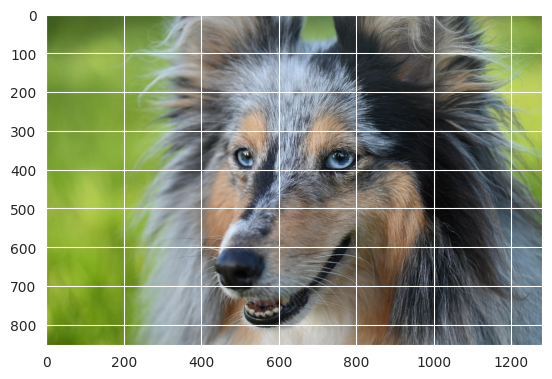

In [158]:
# Contoh gambar
img_path = "/content/anjing_gembala.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [120]:
from keras.layers import TFSMLayer
from keras.models import Sequential
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


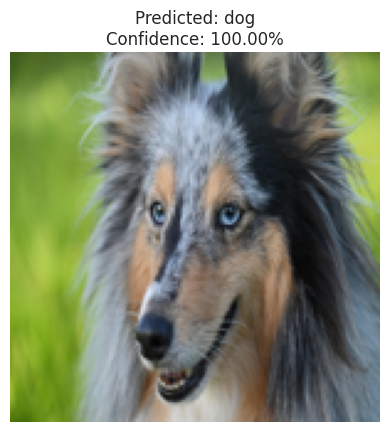

In [159]:
model_path = "/content/Dataset-Final/SavedModel"
model = Sequential([
    TFSMLayer(model_path, call_endpoint='serving_default')
])

# Menyesuaikan gambar
img = Image.open(img_path).resize((150, 150))
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Klasifikasi gambar
predictions = model.predict(img_array)
pred_array = predictions['output_0']

class_names = ['cat', 'dog', 'wild']
predicted_class = class_names[np.argmax(pred_array)]
confidence = np.max(pred_array) * 100

# Tampilkan hasil
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}%")
plt.axis('off')
plt.show()

Untuk memuat model dalam format SavedModel di Keras 3, dapat digunakan keras.layers.TFSMLayer dengan sintaks keras.layers.TFSMLayer() yang akan memuat model sebagai lapisan inferensi.

**Kesimpulan :**
- Berdasarkan classification report di atas, model menunjukkan performa yang sangat baik dalam mengklasifikasikan tiga kelas gambar dengan akurasi keseluruhan sebesar 95.81%.

- Pada kelas Dog, model memiliki recall yang sangat tinggi (97.05%), menunjukkan kemampuannya dalam mendeteksi sebagian besar gambar anjing. Namun, precision-nya sedikit lebih rendah (93.73%), yang mengindikasikan adanya beberapa kasus di mana gambar bukan anjing salah diklasifikasikan sebagai Dog.

- Sementara itu, kelas Wild mencatat precision tertinggi (96.95%), artinya ketika model memprediksi suatu gambar sebagai "Wild", prediksinya hampir selalu benar. Namun, recall-nya (93.52%) lebih rendah dibandingkan kelas lainnya, yang berarti masih ada beberapa gambar Wild yang tidak terdeteksi oleh model.

Secara keseluruhan, model ini bekerja dengan baik untuk klasifikasi tiga kelas, dengan F1-score di atas 95% untuk semua kategori.

